# steps

1. import water body 
1. get bounds
1. format bounds to string
1. use requests to download geojson for area
1. calculate overlap 
1. add data to shapes


In [35]:
# import helper functions 

# add helper function location
import sys 
sys.path.append('../../functions')

from helpers import *

In [36]:
import overpass
import fiona
import glob

from shapely.ops import cascaded_union, unary_union
from shapely.geometry import shape, Point

In [37]:
# parameters 
results_files_location = '../../data/nir_green_blue/vectors/'

persil_data_store_location = '../../data/nir_green_blue/persil_overlap/'

geoserver_url = 'https://geosvc.atrbpn.go.id/geoserver/petabpn/'

In [38]:
# create download directory if it does not exist
make_dir(results_files_location)
make_dir(persil_data_store_location)    

Directory  ../../data/nir_green_blue/vectors/  already exists...
Directory  ../../data/nir_green_blue/persil_overlap/  already exists...


In [97]:
len(result_file_list)

446

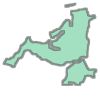

In [115]:
result_file_list = glob.glob(results_files_location + '*.geojson')

result_file_path = result_file_list[200]

# convert esri shapefiles to shapely objects
# check valid geometries
list, result_valid_shape_list, crs_check = check_valid_geometries(result_file_path)

if not crs_check:
    print('crs not epsg:4623, skipping...')


# convert list to shapely MultiPolgyons (in wgs84)
result_wgs_shp = unary_union([shape(pol['geometry']) for pol in result_valid_shape_list])

result_wgs_shp

In [116]:
basename = os.path.basename(result_file_path).split('.')[0]

In [117]:
xmin, ymin, xmax, ymax = result_wgs_shp.bounds ##116.875357555,-1.256141483,116.881267105,-1.248372542

max_features = 100000

xmin, ymin, xmax, ymax, max_features

(106.62365005308301,
 -6.332677025415021,
 106.62910687126482,
 -6.327893230948617,
 100000)

In [118]:
url = geoserver_url + 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=petabpn:PersilBerdasarkanJenisHak&maxFeatures={}&outputFormat=application%2Fjson&BBOX={},{},{},{}'.format(
        max_features, xmin, ymin, xmax, ymax)

local = persil_data_store_location + basename + '.geojson'

In [119]:
download_file(url, local)

'../../data/nir_green_blue/persil_overlap/Jakarta_352_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.geojson'

In [120]:
import fiona
from shapely.geometry import shape
from shapely.ops import unary_union

In [121]:
valid_geom, data, crs_check = check_valid_geometries(local)

polygon_list_wgs_shp = [shape(pol['geometry']) for pol in valid_geom]

typehak = []
for feature in data:
    typehak.append(feature['properties']['TIPEHAK'])

import geopandas as gpd

series = gpd.GeoSeries(polygon_list_wgs_shp)

gdf = gpd.GeoDataFrame(geometry = series)

In [122]:
len(gdf)

45

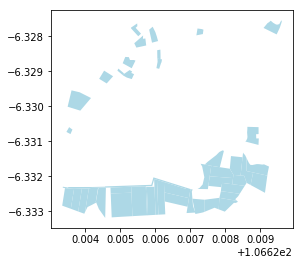

In [123]:
# We can now plot our ``GeoDataFrame``.
gdf.plot(color='lightblue', facecolor = 'blue')

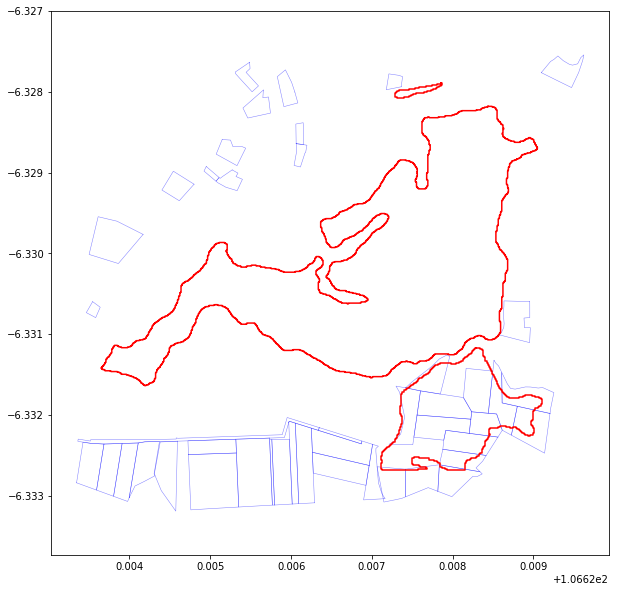

In [124]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))

    
for percil in gdf.geometry:
    try:
        x,y = [poly.boundary.xy for poly in percil][0]
    except: 
        x,y = [poly.exterior.xy for poly in percil][0]
    plt.plot(x,y, color = 'b', linewidth=0.5, alpha = 0.5)
        

for water in result_wgs_shp:
    try:
        x,y = water.boundary.xy
    except:
        x,y = water.exterior.xy
        
    plt.plot(x,y, color = 'r')


plt.axis('equal')


plt.show()

In [54]:
len([poly.boundary.xy for poly in percil]

1

In [48]:
x,y = result_wgs_shp.exterior.xy

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [166]:
import folium



import pandas as pd

try:
    x,y = result_wgs_shp[0].centroid.xy
except:
    x,y = result_wgs_shp.centroid.xy

m = folium.Map(location=[y[0], x[0]], zoom_start=16, max_zoom = 30)

for poly in polygon_list_wgs_shp[0:500]:
    folium.Choropleth(
        geo_data=poly,
        legend_name='persil data'
    ).add_to(m)
    

for poly in [result_wgs_shp]:
    folium.Choropleth(
        geo_data=poly, 
        name='detected water',
    ).add_to(m)


folium.LayerControl().add_to(m)

m

In [167]:
dict((i, typehak.count(i)) for i in typehak)

{'Hak Pakai': 1, 'Hak Guna Bangunan': 38, 'Hak Milik': 27, 'Kosong': 6}

In [168]:
import numpy as np
import matplotlib.pyplot as plt

In [169]:
typehak_count = [typehak.count(i) for i in np.unique(typehak)]

Text(0, 0.5, 'number of occurences')

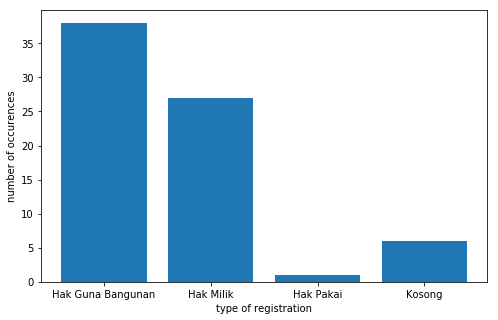

In [170]:
plt.figure(figsize = (2*len(np.unique(typehak)), 5))
plt.bar(np.unique(typehak), typehak_count)
plt.xlabel('type of registration')
plt.ylabel('number of occurences')